In [1]:
# Importing the necessary libraries

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import os
import time
import copy
import pandas as pd
from PIL import Image
from torchvision import datasets, models, transforms

In [2]:
# Defining the needed parameters

dataset_dir = '../Dataset'
model_name = 'alexnet'
num_classes = 15
batch_size = 128
num_epochs = 500
feature_extract = True

In [3]:
# Loading the data

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(dataset_dir, x), data_transforms[x]) for x in ['train', 'val']}

dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

In [4]:
# Detecting GPU

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
# Getting the GPU name

torch.cuda.get_device_name(0)

'GeForce 840M'

In [6]:
# Reshaping and initializing the model

def initialize_alexnet(model_name, num_classes, feature_extract=True, use_pretrained=True):

  model_ft = None
  input_size = 0

  if model_name == "alexnet":
    model_ft = models.alexnet(pretrained=use_pretrained)

    if feature_extract:
        for param in model_ft.parameters():
            param.requires_grad = False
    
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)

    input_size = 224
  else:
        print("Model name is invalid!")
        exit()

  return model_ft,input_size

model_ft, input_size = initialize_alexnet(model_name, num_classes, feature_extract)

print(model_ft)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [7]:
# Creating the optimizer

model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
print("Parameters to learn")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

optimizer_ft = optim.SGD(params_to_update, lr=0.01, momentum=0.9)

Parameters to learn
	 classifier.6.weight
	 classifier.6.bias


In [8]:
# Training the model

def train_model(model, dataloaders, criterion, optimizer, num_epochs=500):
    since = time.time()

    val_acc_history = []
    train_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch: {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 30)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            else: 
                train_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('-' * 35)
    print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best validation accuracy: {:4f}'.format(best_acc))
    print('-' * 35)

    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history

criterion = nn.CrossEntropyLoss()

model_ft, val_hist, train_hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch: 1/500
------------------------------
train Loss: 1.2188 Acc: 0.6366
val Loss: 0.8985 Acc: 0.7633

Epoch: 2/500
------------------------------
train Loss: 0.9753 Acc: 0.7075
val Loss: 0.8462 Acc: 0.7985

Epoch: 3/500
------------------------------
train Loss: 0.9371 Acc: 0.7241
val Loss: 0.7071 Acc: 0.8106

Epoch: 4/500
------------------------------
train Loss: 0.9057 Acc: 0.7349
val Loss: 0.8687 Acc: 0.7964

Epoch: 5/500
------------------------------
train Loss: 0.9502 Acc: 0.7311
val Loss: 0.4859 Acc: 0.8564

Epoch: 6/500
------------------------------
train Loss: 0.8995 Acc: 0.7415
val Loss: 0.5959 Acc: 0.8327

Epoch: 7/500
------------------------------
train Loss: 0.8968 Acc: 0.7414
val Loss: 0.8496 Acc: 0.7896

Epoch: 8/500
------------------------------
train Loss: 0.8986 Acc: 0.7467
val Loss: 1.2611 Acc: 0.7454

Epoch: 9/500
------------------------------
train Loss: 0.8722 Acc: 0.7523
val Loss: 0.6390 Acc: 0.8385

Epoch: 10/500
------------------------------
train Loss

train Loss: 0.8309 Acc: 0.7746
val Loss: 0.5052 Acc: 0.8643

Epoch: 79/500
------------------------------
train Loss: 0.8013 Acc: 0.7791
val Loss: 0.7477 Acc: 0.8127

Epoch: 80/500
------------------------------
train Loss: 0.8574 Acc: 0.7736
val Loss: 0.5127 Acc: 0.8643

Epoch: 81/500
------------------------------
train Loss: 0.8234 Acc: 0.7788
val Loss: 0.5026 Acc: 0.8680

Epoch: 82/500
------------------------------
train Loss: 0.8319 Acc: 0.7727
val Loss: 0.8693 Acc: 0.8217

Epoch: 83/500
------------------------------
train Loss: 0.8143 Acc: 0.7820
val Loss: 0.9825 Acc: 0.8054

Epoch: 84/500
------------------------------
train Loss: 0.8617 Acc: 0.7738
val Loss: 0.4449 Acc: 0.8843

Epoch: 85/500
------------------------------
train Loss: 0.7957 Acc: 0.7807
val Loss: 0.8059 Acc: 0.8101

Epoch: 86/500
------------------------------
train Loss: 0.8500 Acc: 0.7739
val Loss: 0.4947 Acc: 0.8690

Epoch: 87/500
------------------------------
train Loss: 0.8267 Acc: 0.7754
val Loss: 0.670

train Loss: 0.7982 Acc: 0.7830
val Loss: 0.5649 Acc: 0.8585

Epoch: 156/500
------------------------------
train Loss: 0.8243 Acc: 0.7781
val Loss: 0.5277 Acc: 0.8695

Epoch: 157/500
------------------------------
train Loss: 0.8344 Acc: 0.7818
val Loss: 0.5580 Acc: 0.8701

Epoch: 158/500
------------------------------
train Loss: 0.8015 Acc: 0.7776
val Loss: 0.7166 Acc: 0.8396

Epoch: 159/500
------------------------------
train Loss: 0.8029 Acc: 0.7848
val Loss: 0.8127 Acc: 0.8217

Epoch: 160/500
------------------------------
train Loss: 0.9995 Acc: 0.7661
val Loss: 0.8415 Acc: 0.8164

Epoch: 161/500
------------------------------
train Loss: 0.7851 Acc: 0.7869
val Loss: 0.4331 Acc: 0.8869

Epoch: 162/500
------------------------------
train Loss: 0.8217 Acc: 0.7787
val Loss: 0.7338 Acc: 0.8290

Epoch: 163/500
------------------------------
train Loss: 0.8164 Acc: 0.7792
val Loss: 0.6647 Acc: 0.8396

Epoch: 164/500
------------------------------
train Loss: 0.8018 Acc: 0.7813
val Lo

train Loss: 0.8143 Acc: 0.7829
val Loss: 0.8373 Acc: 0.8206

Epoch: 233/500
------------------------------
train Loss: 0.7774 Acc: 0.7902
val Loss: 0.8862 Acc: 0.8143

Epoch: 234/500
------------------------------
train Loss: 0.8204 Acc: 0.7814
val Loss: 0.4517 Acc: 0.8822

Epoch: 235/500
------------------------------
train Loss: 0.8065 Acc: 0.7813
val Loss: 0.6883 Acc: 0.8306

Epoch: 236/500
------------------------------
train Loss: 0.8244 Acc: 0.7813
val Loss: 0.5466 Acc: 0.8590

Epoch: 237/500
------------------------------
train Loss: 0.7944 Acc: 0.7837
val Loss: 0.5823 Acc: 0.8517

Epoch: 238/500
------------------------------
train Loss: 0.8216 Acc: 0.7824
val Loss: 0.5438 Acc: 0.8690

Epoch: 239/500
------------------------------
train Loss: 0.8089 Acc: 0.7780
val Loss: 0.5924 Acc: 0.8496

Epoch: 240/500
------------------------------
train Loss: 0.7747 Acc: 0.7895
val Loss: 0.5953 Acc: 0.8553

Epoch: 241/500
------------------------------
train Loss: 0.7788 Acc: 0.7838
val Lo

train Loss: 0.8012 Acc: 0.7830
val Loss: 0.5670 Acc: 0.8701

Epoch: 310/500
------------------------------
train Loss: 0.8808 Acc: 0.7790
val Loss: 0.7333 Acc: 0.8369

Epoch: 311/500
------------------------------
train Loss: 0.8144 Acc: 0.7856
val Loss: 0.6972 Acc: 0.8438

Epoch: 312/500
------------------------------
train Loss: 0.7682 Acc: 0.7906
val Loss: 0.5302 Acc: 0.8601

Epoch: 313/500
------------------------------
train Loss: 0.8112 Acc: 0.7823
val Loss: 0.7478 Acc: 0.8406

Epoch: 314/500
------------------------------
train Loss: 0.8063 Acc: 0.7863
val Loss: 0.7900 Acc: 0.8206

Epoch: 315/500
------------------------------
train Loss: 0.7803 Acc: 0.7933
val Loss: 0.5109 Acc: 0.8706

Epoch: 316/500
------------------------------
train Loss: 0.8171 Acc: 0.7867
val Loss: 0.8936 Acc: 0.8012

Epoch: 317/500
------------------------------
train Loss: 0.8092 Acc: 0.7875
val Loss: 0.6976 Acc: 0.8401

Epoch: 318/500
------------------------------
train Loss: 0.7871 Acc: 0.7905
val Lo

train Loss: 0.8112 Acc: 0.7862
val Loss: 0.7283 Acc: 0.8364

Epoch: 387/500
------------------------------
train Loss: 0.8050 Acc: 0.7839
val Loss: 0.7694 Acc: 0.8364

Epoch: 388/500
------------------------------
train Loss: 0.8868 Acc: 0.7742
val Loss: 0.6566 Acc: 0.8422

Epoch: 389/500
------------------------------
train Loss: 0.8335 Acc: 0.7809
val Loss: 0.6812 Acc: 0.8432

Epoch: 390/500
------------------------------
train Loss: 0.7916 Acc: 0.7872
val Loss: 0.6441 Acc: 0.8553

Epoch: 391/500
------------------------------
train Loss: 0.8144 Acc: 0.7854
val Loss: 0.6260 Acc: 0.8517

Epoch: 392/500
------------------------------
train Loss: 0.8409 Acc: 0.7787
val Loss: 0.8419 Acc: 0.8254

Epoch: 393/500
------------------------------
train Loss: 0.8121 Acc: 0.7841
val Loss: 0.4001 Acc: 0.8874

Epoch: 394/500
------------------------------
train Loss: 0.7757 Acc: 0.7885
val Loss: 0.6893 Acc: 0.8453

Epoch: 395/500
------------------------------
train Loss: 0.8026 Acc: 0.7860
val Lo

train Loss: 0.8008 Acc: 0.7893
val Loss: 0.5794 Acc: 0.8522

Epoch: 464/500
------------------------------
train Loss: 0.8075 Acc: 0.7876
val Loss: 0.6974 Acc: 0.8264

Epoch: 465/500
------------------------------
train Loss: 0.8098 Acc: 0.7861
val Loss: 0.7025 Acc: 0.8411

Epoch: 466/500
------------------------------
train Loss: 0.8181 Acc: 0.7887
val Loss: 0.6112 Acc: 0.8585

Epoch: 467/500
------------------------------
train Loss: 0.7829 Acc: 0.7886
val Loss: 0.4885 Acc: 0.8738

Epoch: 468/500
------------------------------
train Loss: 0.7827 Acc: 0.7950
val Loss: 0.5423 Acc: 0.8632

Epoch: 469/500
------------------------------
train Loss: 0.8109 Acc: 0.7874
val Loss: 0.6833 Acc: 0.8417

Epoch: 470/500
------------------------------
train Loss: 0.8205 Acc: 0.7854
val Loss: 0.9438 Acc: 0.8238

Epoch: 471/500
------------------------------
train Loss: 0.8272 Acc: 0.7855
val Loss: 0.8531 Acc: 0.8254

Epoch: 472/500
------------------------------
train Loss: 0.8219 Acc: 0.7854
val Lo

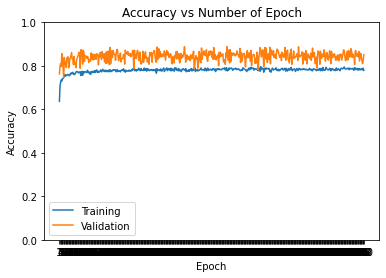

In [9]:
# Getting the learning process history in graph

plt.title("Accuracy vs Number of Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(range(1,num_epochs+1),train_hist,label="Training")
plt.plot(range(1,num_epochs+1),val_hist,label="Validation")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [10]:
# Saving the model

model_path = '../Model/Pesticides_Prescription_Model.sav'
torch.save(model_ft.state_dict(), model_path)

In [11]:
# Saving the class labels

class_labels_path = '../Model/Class_Labels_Pesticides_Prescription_Model.csv'

def save_class_labels(class_labels_path):
    labels_dict = image_datasets['train'].class_to_idx
    labels_df = pd.DataFrame.from_dict(data=labels_dict, orient='index', columns=['idx'])
    labels_df['Label'] = labels_df.index
    labels_df.reset_index(drop=True, inplace=True)
    labels_df.to_csv(class_labels_path, header=None, index=False)

save_class_labels(class_labels_path)